# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import ast
import time

import pickle

from gensim.models import Word2Vec, Doc2Vec
from scipy.sparse import load_npz

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # For feature preprocessing
from sklearn.impute import SimpleImputer # For handling potential NaNs in features

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset # Hugging Face Dataset object

# Configuration

In [4]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

FULL_FEATURES_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'final_NEW.csv')
EMBEDDINGS_DIR = os.path.join(BASE_DIR, 'models_saved', 'embeddings')

TFIDF_VECTORS_PATH = os.path.join(EMBEDDINGS_DIR, "tfidf_vectors.npz")
TFIDF_VECTORIZER_PATH = os.path.join(EMBEDDINGS_DIR, "tfidf_vectorizer.pkl")
ROBERT_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "robert_cls_embeddings.npy")
W2V_MODEL_PATH = os.path.join(EMBEDDINGS_DIR, f"word2vec_300d.model")
D2V_MODEL_PATH = os.path.join(EMBEDDINGS_DIR, f"doc2vec_300d.model")

CLASSIFICATION_MODELS_DIR = os.path.join(BASE_DIR, 'models_saved', 'classification')
EXPERIMENT_A_MODELS_DIR = os.path.join(CLASSIFICATION_MODELS_DIR, 'experiment_a')
EXPERIMENT_B_MODELS_DIR = os.path.join(CLASSIFICATION_MODELS_DIR, 'experiment_b')
CLASSIFICATION_RESULTS_DIR = os.path.join(BASE_DIR, 'visualizations', 'classification_results')

os.makedirs(CLASSIFICATION_MODELS_DIR, exist_ok=True)
os.makedirs(EXPERIMENT_A_MODELS_DIR, exist_ok=True)
os.makedirs(EXPERIMENT_B_MODELS_DIR, exist_ok=True)
os.makedirs(CLASSIFICATION_RESULTS_DIR, exist_ok=True)

# Experiment A

#### Load Data and Pre-trained Models

In [5]:
def parse_list_literal(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df = pd.read_csv(FULL_FEATURES_DATA_PATH, converters={'lemmas_filtered': parse_list_literal})

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['tag'])
print(f"Labels loaded and encoded. Total samples: {len(y)}")
print(f"Classes found and their encoded values: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


try:
    X_tfidf = load_npz(TFIDF_VECTORS_PATH)
    print(f"TF-IDF matrix loaded. Shape: {X_tfidf.shape}")

    X_robert = np.load(ROBERT_EMBEDDINGS_PATH)
    print(f"RoBERT embeddings loaded. Shape: {X_robert.shape}")

    w2v_model = Word2Vec.load(W2V_MODEL_PATH)
    print("Word2Vec model loaded.")
    d2v_model = Doc2Vec.load(D2V_MODEL_PATH)
    print("Doc2Vec model loaded.")
    
    all_data_loaded = True
except FileNotFoundError as e:
    print(f"\nError: Could not find a required file. {e}")
    print("Please ensure all previous feature extraction steps were completed successfully.")
    all_data_loaded = False

Labels loaded and encoded. Total samples: 4334
Classes found and their encoded values: {'fake_news': 0, 'misinformation': 1, 'propaganda': 2, 'real_news': 3, 'satire': 4}
TF-IDF matrix loaded. Shape: (4334, 10000)
RoBERT embeddings loaded. Shape: (4334, 768)
Word2Vec model loaded.
Doc2Vec model loaded.


#### Generate Word2Vec and Doc2Vec Feature Matrices

In [6]:
def get_document_vector_w2v(doc_tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    
    if not vectors:
        return np.zeros(vector_size)
    
    return np.mean(vectors, axis=0)

In [7]:
if all_data_loaded:
    X_word2vec = np.array([
        get_document_vector_w2v(tokens, w2v_model, w2v_model.vector_size) 
        for tokens in tqdm(df['lemmas_filtered'], desc="Averaging Word2Vec")
    ])
    print(f"Word2Vec document vectors created. Shape: {X_word2vec.shape}")

    X_doc2vec = np.array([d2v_model.dv[i] for i in range(len(df))])
    print(f"Doc2Vec document vectors created. Shape: {X_doc2vec.shape}")

Averaging Word2Vec:   0%|          | 0/4334 [00:00<?, ?it/s]

Word2Vec document vectors created. Shape: (4334, 300)
Doc2Vec document vectors created. Shape: (4334, 300)


#### Cross-Validation Experiment Function

In [8]:
def run_cross_validation_experiment(X, y, method_name, save_dir, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_scores = []

    for fold, (train_indices, test_indices) in enumerate(tqdm(skf.split(X, y), total=n_splits, desc=f"CV for {method_name}")):
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        clf = SVC(random_state=42)
        clf.fit(X_train, y_train)
        
        model_filename = f"svm_{method_name}_fold_{fold+1}.pkl"
        model_save_path = os.path.join(save_dir, model_filename)
        
        try:
            with open(model_save_path, 'wb') as f:
                pickle.dump(clf, f)
        except Exception as e:
            print(f"Error saving model for fold {fold+1} of {method_name}: {e}")

        y_pred = clf.predict(X_test)
        
        scores = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'f1_score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
        }
        fold_scores.append(scores)
        
    print(f"Completed cross-validation for {method_name}. All models saved.")
    return fold_scores

#### Run All Experiments

In [9]:
if all_data_loaded:
    feature_sets = {
        "TF-IDF": X_tfidf,
        "Word2Vec (Averaged)": X_word2vec,
        "Doc2Vec": X_doc2vec,
        "RoBERT (CLS)": X_robert
    }
    
    all_experiment_results = {}

    for name, X_features in feature_sets.items():
        print(f"\n----- Running Experiment for: {name} -----")
        
        safe_method_name = name.lower().replace(' ', '_').replace('(', '').replace(')', '')
        
        all_experiment_results[name] = run_cross_validation_experiment(
            X=X_features, 
            y=y, 
            method_name=safe_method_name,
            save_dir=EXPERIMENT_A_MODELS_DIR 
        )
        print(f"----- Experiment for {name} complete -----")

else:
    print("Cannot run experiments because data/models were not loaded correctly.")


----- Running Experiment for: TF-IDF -----


CV for tf-idf:   0%|          | 0/5 [00:00<?, ?it/s]

Completed cross-validation for tf-idf. All models saved.
----- Experiment for TF-IDF complete -----

----- Running Experiment for: Word2Vec (Averaged) -----


CV for word2vec_averaged:   0%|          | 0/5 [00:00<?, ?it/s]

Completed cross-validation for word2vec_averaged. All models saved.
----- Experiment for Word2Vec (Averaged) complete -----

----- Running Experiment for: Doc2Vec -----


CV for doc2vec:   0%|          | 0/5 [00:00<?, ?it/s]

Completed cross-validation for doc2vec. All models saved.
----- Experiment for Doc2Vec complete -----

----- Running Experiment for: RoBERT (CLS) -----


CV for robert_cls:   0%|          | 0/5 [00:00<?, ?it/s]

Completed cross-validation for robert_cls. All models saved.
----- Experiment for RoBERT (CLS) complete -----


#### Dispaly Final Results Table

In [10]:
if 'all_experiment_results' in globals() and all_experiment_results:
    results_summary = []

    for name, fold_scores in all_experiment_results.items():
        df_scores = pd.DataFrame(fold_scores)
        
        summary = {
            "Method": name,
            "Mean Accuracy": f"{df_scores['accuracy'].mean():.4f} ± {df_scores['accuracy'].std():.4f}",
            "Mean Precision": f"{df_scores['precision'].mean():.4f} ± {df_scores['precision'].std():.4f}",
            "Mean Recall": f"{df_scores['recall'].mean():.4f} ± {df_scores['recall'].std():.4f}",
            "Mean F1-Score": f"{df_scores['f1_score'].mean():.4f} ± {df_scores['f1_score'].std():.4f}"
        }
        results_summary.append(summary)
        
    df_final_results = pd.DataFrame(results_summary)
    
    display(df_final_results)
else:
    print("Experiments were not run. No results to display.")

,Method,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score
0,TF-IDF,0.9571 ± 0.0068,0.9578 ± 0.0061,0.9571 ± 0.0068,0.9570 ± 0.0067
1,Word2Vec (Averaged),0.7702 ± 0.0106,0.7682 ± 0.0119,0.7702 ± 0.0106,0.7686 ± 0.0113
2,Doc2Vec,0.8087 ± 0.0109,0.8057 ± 0.0114,0.8087 ± 0.0109,0.8046 ± 0.0117
3,RoBERT (CLS),0.7425 ± 0.0056,0.7371 ± 0.0063,0.7425 ± 0.0056,0.7376 ± 0.0072


# Re-train The Best Method on Full Data for Final Model in UI Based on Experiment A

In [11]:
def parse_list_literal(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

In [12]:
try:    
    df = pd.read_csv(FULL_FEATURES_DATA_PATH, converters={'lemmas_filtered': parse_list_literal})

    if 'lemmas_filtered' in df.columns and not df['lemmas_filtered'].isnull().all():        
        prepared_documents = df['lemmas_filtered'].apply(
            lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else ''
        ).tolist()
        
        print(f"Successfully prepared {len(prepared_documents)} documents for TF-IDF vectorization.")
    else:
        print("Error: 'lemmas_filtered' column not found or is empty.")
        prepared_documents = None
except FileNotFoundError:
    print(f"Error: Processed data file not found at {FULL_FEATURES_DATA_PATH}")
    prepared_documents = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    prepared_documents = None

Successfully prepared 4334 documents for TF-IDF vectorization.


In [18]:
print("Fitting final TF-IDF vectorizer on 100% of the data...")
final_tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=5,
    max_features=10000
)
X_final_tfidf = final_tfidf_vectorizer.fit_transform(prepared_documents)
print("Final TF-IDF matrix created.")

Fitting final TF-IDF vectorizer on 100% of the data...
Final TF-IDF matrix created.


In [21]:
print("Training final SVM classifier on 100% of the data...")
final_svm_model = SVC(random_state=42, probability=True)
final_svm_model.fit(X_final_tfidf, y)
print("Final SVM model trained.")

Training final SVM classifier on 100% of the data...
Final SVM model trained.


In [22]:
with open(os.path.join(CLASSIFICATION_MODELS_DIR, "final_tfidf_vectorizer.pkl"), 'wb') as f:
    pickle.dump(final_tfidf_vectorizer, f)

with open(os.path.join(CLASSIFICATION_MODELS_DIR, "final_svm_model.pkl"), 'wb') as f:
    pickle.dump(final_svm_model, f)

print("Final production-ready models saved.")

Final production-ready models saved.


# Experiment B

#### Load Data for Clustering

In [13]:
try:
    d2v_model = Doc2Vec.load(D2V_MODEL_PATH)

    df = pd.read_csv(FULL_FEATURES_DATA_PATH)
    
    X_doc2vec = np.array([d2v_model.dv[i] for i in range(len(df))])
    
    print(f"Successfully loaded Doc2Vec vectors. Shape: {X_doc2vec.shape}")
    data_loaded_for_clustering = True

except FileNotFoundError as e:
    print(f"Error: Could not find a required file. {e}")
    data_loaded_for_clustering = False

Successfully loaded Doc2Vec vectors. Shape: (4334, 300)


#### Find the optimal 'k' using the Elbow Method 

Running k-Means for different k:   0%|          | 0/19 [00:00<?, ?it/s]

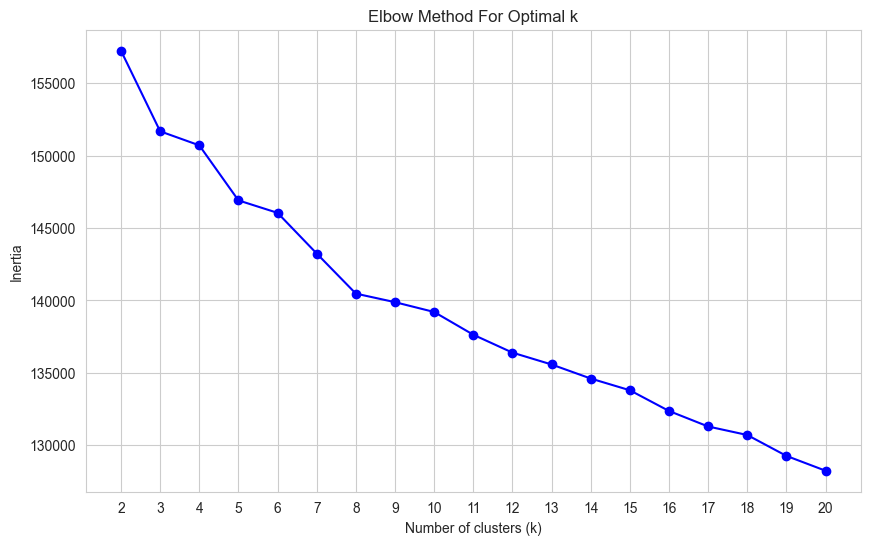

In [14]:
if data_loaded_for_clustering:    
    inertia_values = []
    k_range = range(2, 21)

    for k in tqdm(k_range, desc="Running k-Means for different k"):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
        kmeans.fit(X_doc2vec)
        inertia_values.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_values, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig(os.path.join(CLASSIFICATION_RESULTS_DIR, "elbow_method_k_means.png"))
    plt.show()

else:
    print("Cannot run Elbow Method because data was not loaded correctly.")

#### Load Data and Pre-trained Models

In [15]:
def parse_list_literal(x):
    try: return ast.literal_eval(x)
    except (ValueError, SyntaxError): return []
df = pd.read_csv(FULL_FEATURES_DATA_PATH, converters={'lemmas_filtered': parse_list_literal})

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['tag'])
print(f"Labels loaded. Total samples: {len(y)}")

engineered_feature_columns = [
    'word_count', 'vocabulary_richness', 'noun_prop', 'verb_prop', 
    'adj_prop', 'adv_prop', 'total_entities', 'entity_density', 
    'anger_mean', 'joy_mean', 'sadness_mean', 'trust_mean', 
    'anticipation_mean', 'disgust_mean', 'fear_mean', 'surprise_mean', 
    'Positivity', 'Negativity', 'matched_emotion_words', 
    'percentage_positive_specific', 'percentage_negative_specific'
]
X_engineered = df[engineered_feature_columns].values
print(f"Engineered features loaded. Shape: {X_engineered.shape}")

d2v_model = Doc2Vec.load(D2V_MODEL_PATH)
X_doc2vec = np.array([d2v_model.dv[i] for i in range(len(df))])
print(f"Doc2Vec embeddings loaded. Shape: {X_doc2vec.shape}")

Labels loaded. Total samples: 4334
Engineered features loaded. Shape: (4334, 21)
Doc2Vec embeddings loaded. Shape: (4334, 300)


#### Hyperparameter Tuning with GridSearchCV

In [80]:
K_CLUSTERS = 8

scaler_for_tuning = StandardScaler()
X_engineered_scaled = scaler_for_tuning.fit_transform(X_engineered)

kmeans_for_tuning = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
cluster_ids = kmeans_for_tuning.fit_predict(X_doc2vec).reshape(-1, 1)

X_hybrid_full = np.hstack((X_doc2vec, X_engineered_scaled, cluster_ids))
print(f"Full hybrid feature matrix created. Shape: {X_hybrid_full.shape}")

param_grid_svm = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto', 0.1],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted'
)

print("\nStarting GridSearchCV... (This may take several minutes)")
grid_search.fit(X_hybrid_full, y)

best_svm_params = grid_search.best_params_
print(f"\nGridSearchCV Complete.")
print(f"Best SVM parameters found: {best_svm_params}")
print(f"Best internal cross-validation F1-score: {grid_search.best_score_:.4f}")

--- Stage 1: Finding Optimal SVM Hyperparameters ---
Preparing full dataset for GridSearchCV...
Full hybrid feature matrix created. Shape: (4334, 322)

Starting GridSearchCV... (This may take several minutes)
Fitting 3 folds for each of 18 candidates, totalling 54 fits

GridSearchCV Complete.
Best SVM parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best internal cross-validation F1-score: 0.8677
(Note: This score is an estimate and should not be reported as the final result)


#### Pipeline Function

In [86]:
def run_experiment_b_pipeline(X_engineered, X_doc2vec, y, k, svm_params, save_dir, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []
    
    exp_b_save_dir = os.path.join(save_dir, "experiment_b_models")
    os.makedirs(exp_b_save_dir, exist_ok=True)

    for fold, (train_indices, test_indices) in enumerate(tqdm(skf.split(X_engineered, y), total=n_splits, desc="Running Hybrid Model CV")):
        X_eng_train, X_eng_test = X_engineered[train_indices], X_engineered[test_indices]
        X_doc_train, X_doc_test = X_doc2vec[train_indices], X_doc2vec[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        scaler = StandardScaler()
        X_eng_train_scaled = scaler.fit_transform(X_eng_train)
        X_eng_test_scaled = scaler.transform(X_eng_test)

        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_doc_train)
        cluster_train = kmeans.predict(X_doc_train).reshape(-1, 1)
        cluster_test = kmeans.predict(X_doc_test).reshape(-1, 1)
        
        X_train_final = np.hstack((X_doc_train, X_eng_train_scaled, cluster_train))
        X_test_final = np.hstack((X_doc_test, X_eng_test_scaled, cluster_test))

        clf = SVC(random_state=42, probability=True, **svm_params)
        clf.fit(X_train_final, y_train)

        with open(os.path.join(exp_b_save_dir, f"svm_fold_{fold+1}.pkl"), 'wb') as f: pickle.dump(clf, f)
        with open(os.path.join(exp_b_save_dir, f"scaler_fold_{fold+1}.pkl"), 'wb') as f: pickle.dump(scaler, f)
        with open(os.path.join(exp_b_save_dir, f"kmeans_fold_{fold+1}.pkl"), 'wb') as f: pickle.dump(kmeans, f)

        y_pred = clf.predict(X_test_final)
        
        fold_scores.append({
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'f1_score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
        })

    return fold_scores

#### Execute and Display Results

In [87]:
if 'best_svm_params' in globals():
    print(f"\nFinal Evaluation for Experiment B with Best Params: {best_svm_params}")
    
    experiment_b_results = run_experiment_b_pipeline(
        X_engineered=X_engineered,
        X_doc2vec=X_doc2vec,
        y=y,
        k=K_CLUSTERS,
        svm_params=best_svm_params,
        save_dir=EXPERIMENT_B_MODELS_DIR
    )
    
    df_scores_b = pd.DataFrame(experiment_b_results)
    summary_b = {
        "Method": f"Hybrid Model (Doc2Vec + Engineered + k-Means)",
        "Mean Accuracy": f"{df_scores_b['accuracy'].mean():.4f} ± {df_scores_b['accuracy'].std():.4f}",
        "Mean Precision": f"{df_scores_b['precision'].mean():.4f} ± {df_scores_b['precision'].std():.4f}",
        "Mean Recall": f"{df_scores_b['recall'].mean():.4f} ± {df_scores_b['recall'].std():.4f}",
        "Mean F1-Score": f"{df_scores_b['f1_score'].mean():.4f} ± {df_scores_b['f1_score'].std():.4f}"
    }
    
    df_final_results_b = pd.DataFrame([summary_b])
    
    display(df_final_results_b)

else:
    print("Cannot run final experiment because best SVM parameters were not determined.")


----- Running Final Evaluation for Experiment C with Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'} -----


Running Hybrid Model CV:   0%|          | 0/5 [00:00<?, ?it/s]

Experiment C cross-validation complete.


--- Final, Robust Results for Experiment C ---


,Method,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score
0,Hybrid Model (Doc2Vec + Engineered + k-Means),0.9174 ± 0.0139,0.9188 ± 0.0135,0.9174 ± 0.0139,0.9169 ± 0.0141


#